In [25]:
%load_ext autoreload 
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf

from src.data_processing.pipelines.ClassifierPipe import ClassifierPipe
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
model = tf.keras.models.load_model('/projects/p31961/ENIGMA/results/optimized_models/BaseClassifier_optimized')
metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc-roc')]
  
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

In [ ]:
model.summary()

In [ ]:
DATA_PATH = '/projects/p31961/gaby_data/aggregated_data/raw_data/datasets/raw_data_raw_data.parquet.gzip'
SUBJECT_IDS_PATH = "/projects/p31961/ENIGMA/results/optimized_models/subjects.json"
cols_to_drop = ["mouse_id", "event", "sex", "day", "trial_count", "trial"]
processor = (ClassifierPipe(DATA_PATH)
            .read_raw_data()
            .calculate_max_min_signal()
            .split_data(load_subject_ids=True, 
                        subject_ids_path=SUBJECT_IDS_PATH,
                        target='action')
            .drop_features(cols_to_drop)
            .transform_data(numeric_target_dict={'avoid': 1, 'escape': 0})
            )
processor.processed_data

In [ ]:
cols_to_drop = ["mouse_id", "event", "sex", "day", "trial_count", "trial"]
processor.processed_data.drop(columns = cols_to_drop)

In [ ]:
y_pred = model.predict(processor.X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred

In [ ]:
f1_score_results = f1_score(processor.y_test, y_pred)

In [ ]:
display = ConfusionMatrixDisplay.from_predictions(processor.y_test, y_pred)
plt.text(-.5, -.8, f"F1-score: {np.round(f1_score_results, 2)}", fontsize = 14)
plt.title('Confusion Matrix')

In [33]:
def reconstruct_df(x_data, y_data, prediction, processor):
    num_cols = processor.processor.named_transformers_["num"].get_feature_names_out().tolist()
    cat_cols = processor.processor.named_transformers_["cat"].get_feature_names_out().tolist()
    cols = num_cols + cat_cols


    df = (
        pd.DataFrame(x_data, columns=cols)
        .assign(target=y_data.reset_index(drop=True),
                prediction=prediction.reshape(-1)
                ))
    return (df
            .melt(
            id_vars = df.drop(columns = ["target", "prediction"]).columns,
            value_vars = ["target", "prediction"],
            value_name = "avoid",
            var_name = 'truth'
        )
    )
    
    
    
    


In [ ]:
test_df = reconstruct_df(processor = processor, 
               x_data = processor.X_test, 
               y_data = processor.y_test, 
               prediction = y_pred)
    

In [ ]:
test_df

In [ ]:

sns.kdeplot(data=test_df, x="day", y="avoid", hue = 'truth', palette = ['grey','red'])
# sns.kdeplot(data=test_df, x="day", y="prediction", color = 'grey')

In [ ]:
sns.stripplot(data=test_df, x="avoid",
              y="day",
              hue = 'truth', 
              palette = ['grey','red'],
              dodge = True,
              jitter = True
              )

In [ ]:
sns.violinplot(data=test_df,
               x="avoid",
               y="trial_count",
               hue = 'truth', 
               inner = "stick",
               split = True,
               palette = ['grey','red'])

In [ ]:
processor.raw_data

# Same model trained on FP data only

In [27]:
def process_data(file_path, subject_ids_path,features_to_drop):
    """
    Process the data from a given file path and save the processed data to a specified path.

    Args:
        file_path (str): The path to the file containing the data.
        path_to_save (str): The path to save the processed data.

    Returns:
        ClassifierPipe: The processed data.
    """
    
    processor = (ClassifierPipe(file_path)
                  .read_raw_data()
                  .calculate_max_min_signal()
                  .split_data(load_subject_ids = True, 
                              subject_ids_path = subject_ids_path,
                              target = 'action')
                  .drop_features(features_to_drop)
                  .transform_data(numeric_target_dict={'avoid': 1, 'escape': 0})
                  )
    return processor

In [28]:
DATA_PATH = '/projects/p31961/gaby_data/aggregated_data/raw_data/datasets/raw_data_raw_data.parquet.gzip'


FEATURES_TO_DROP = ["mouse_id", "event", "sex", "day", "trial_count", "trial"]
SUBJECT_IDS_PATH = "/projects/p31961/ENIGMA/results/optimized_models/subjects.json"

In [29]:
processor = process_data(DATA_PATH, SUBJECT_IDS_PATH, FEATURES_TO_DROP)


array([[-0.04836196, -1.20916116,  1.        ,  0.        ,  0.        ],
       [-0.35275251,  0.92475796,  1.        ,  0.        ,  0.        ],
       [ 0.08722621, -0.17411163,  1.        ,  0.        ,  0.        ],
       ...,
       [ 1.11119676, -0.18094854,  0.        ,  0.        ,  1.        ],
       [ 1.75485682, -0.01353156,  0.        ,  0.        ,  1.        ],
       [ 1.24674451,  0.2344276 ,  0.        ,  0.        ,  1.        ]])

In [30]:
fp_only_model = tf.keras.models.load_model('/projects/p31961/ENIGMA/results/optimized_models/BaseClassifier_optimized_fp_only')
metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc-roc')]
  
fp_only_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
fp_only_model.summary()

2023-09-15 15:21:36.693128: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38222 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:06:00.0, compute capability: 8.0
2023-09-15 15:21:36.694938: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38222 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:2f:00.0, compute capability: 8.0


Model: "base_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  multiple                 11        
 n)                                                              
                                                                 
 Dense_0 (Dense)             multiple                  120       
                                                                 
 Dense_1 (Dense)             multiple                  420       
                                                                 
 Dense_2 (Dense)             multiple                  420       
                                                                 
 Dropout (Dropout)           multiple                  0         
                                                                 
 Output (Dense)              multiple                  21        
                                                   

In [35]:
y_pred = fp_only_model.predict(processor.X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

82/82 [==============================] - 0s 1ms/step


In [36]:
fp_only_df = reconstruct_df(processor = processor, 
               x_data = processor.X_test, 
               y_data = processor.y_test, 
               prediction = y_pred)
fp_only_df

,signal_max,signal_min,sensor_D1,sensor_D2,sensor_DA,truth,avoid
0,-0.035918,-0.965276,1.0,0.0,0.0,target,1
1,-0.309250,-0.087967,1.0,0.0,0.0,target,1
2,-1.062241,-0.123046,1.0,0.0,0.0,target,1
3,0.416706,0.756567,1.0,0.0,0.0,target,1
4,-0.062961,-0.681449,1.0,0.0,0.0,target,1
...,...,...,...,...,...,...,...
5241,0.436967,-0.632748,0.0,0.0,1.0,prediction,1
5242,-0.091881,-1.109231,0.0,0.0,1.0,prediction,1
5243,-0.135572,-0.591154,0.0,0.0,1.0,prediction,1
5244,-0.679461,-1.690778,0.0,0.0,1.0,prediction,1


Text(0.5, 1.0, 'Confusion Matrix')

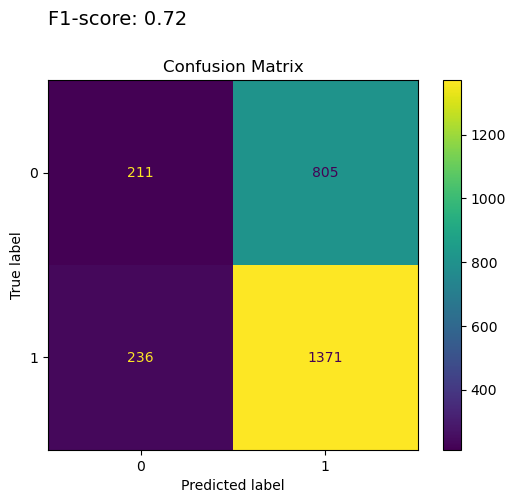

In [37]:
fp_f1_score_results = f1_score(processor.y_test, y_pred)
display = ConfusionMatrixDisplay.from_predictions(processor.y_test, y_pred)
plt.text(-.5, -.8, f"F1-score: {np.round(fp_f1_score_results, 2)}", fontsize = 14)
plt.title('Confusion Matrix')

<Axes: xlabel='avoid', ylabel='signal_max'>

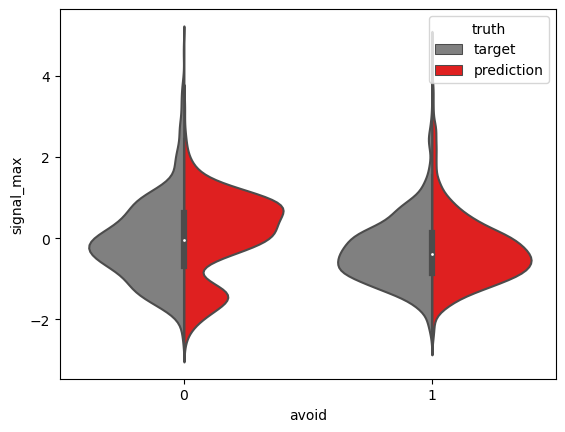

In [40]:
sns.violinplot(data=fp_only_df,
               x = "avoid",
               y = "signal_max",
               hue = 'truth',
            #    inner = "stick",
               split=True,
               palette = ['grey','red'])

<Axes: xlabel='avoid', ylabel='signal_min'>

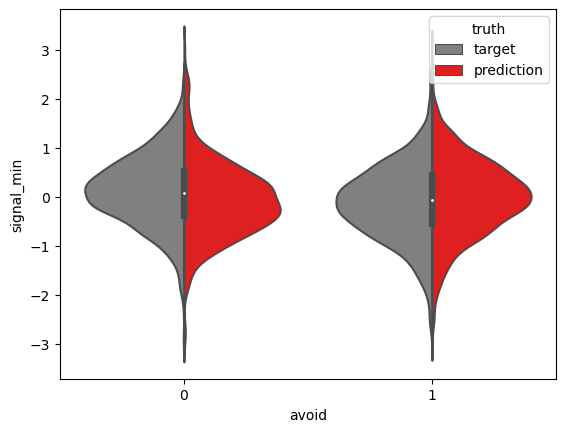

In [41]:
sns.violinplot(data=fp_only_df,
               x = "avoid",
               y = "signal_min",
               hue = 'truth',
            #    inner = "stick",
               split=True,
               palette = ['grey','red'])

<Axes: xlabel='avoid', ylabel='signal_max'>

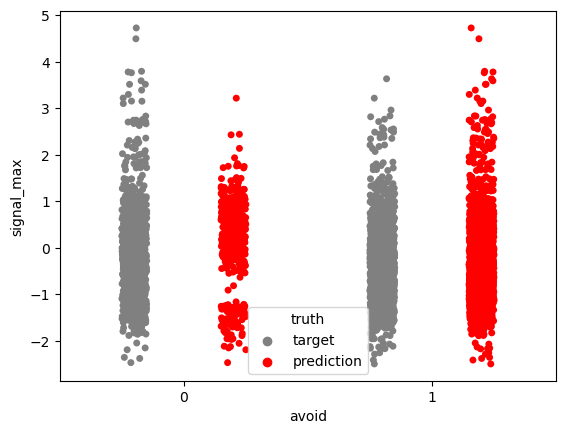

In [42]:
sns.stripplot(data=fp_only_df, 
              x="avoid",
              y="signal_max",
              hue = 'truth', 
              palette = ['grey','red'],
              dodge = True,
              jitter = True
              )

<Axes: xlabel='signal_max', ylabel='avoid'>

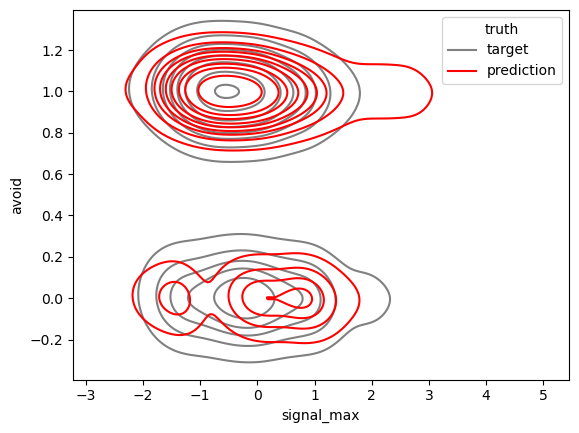

In [44]:
sns.kdeplot(data=fp_only_df, x="signal_max", y="avoid", hue = 'truth', palette = ['grey','red'])

In [45]:
fp_only_df = fp_only_df.assign(signal_range = lambda df_: df_.signal_max - df_.signal_min)

In [46]:
fp_only_df

,signal_max,signal_min,sensor_D1,sensor_D2,sensor_DA,truth,avoid,signal_range
0,-0.035918,-0.965276,1.0,0.0,0.0,target,1,0.929358
1,-0.309250,-0.087967,1.0,0.0,0.0,target,1,-0.221284
2,-1.062241,-0.123046,1.0,0.0,0.0,target,1,-0.939195
3,0.416706,0.756567,1.0,0.0,0.0,target,1,-0.339861
4,-0.062961,-0.681449,1.0,0.0,0.0,target,1,0.618487
...,...,...,...,...,...,...,...,...
5241,0.436967,-0.632748,0.0,0.0,1.0,prediction,1,1.069715
5242,-0.091881,-1.109231,0.0,0.0,1.0,prediction,1,1.017350
5243,-0.135572,-0.591154,0.0,0.0,1.0,prediction,1,0.455582
5244,-0.679461,-1.690778,0.0,0.0,1.0,prediction,1,1.011318


<Axes: xlabel='avoid', ylabel='signal_range'>

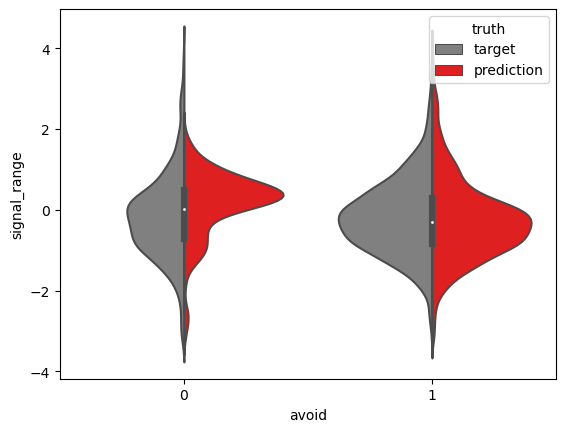

In [49]:
sns.violinplot(data=fp_only_df,
               x = "avoid",
               y = "signal_range",
               hue = 'truth',
               split = True,
               palette = ['grey','red'])

<Axes: xlabel='avoid', ylabel='signal_range'>

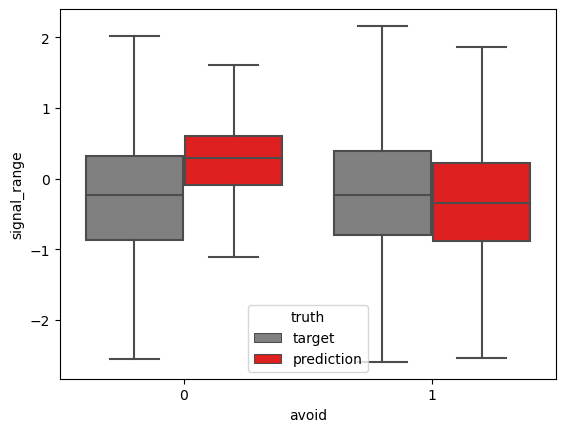

In [57]:
sns.boxplot(data=fp_only_df,x = 'avoid', y = 'signal_range', hue = 'truth', palette = ['grey','red'], showfliers = False)

In [58]:
#dopamine only
da_only = fp_only_df.query("sensor_DA == 1")

<Axes: xlabel='avoid', ylabel='signal_range'>

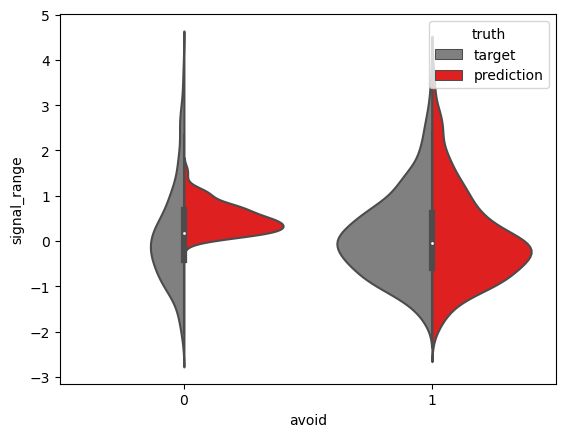

In [59]:
sns.violinplot(data=da_only,
               x = "avoid",
               y = "signal_range",
               hue = 'truth',
               split = True,
               palette = ['grey','red'])

<Axes: xlabel='avoid', ylabel='signal_max'>

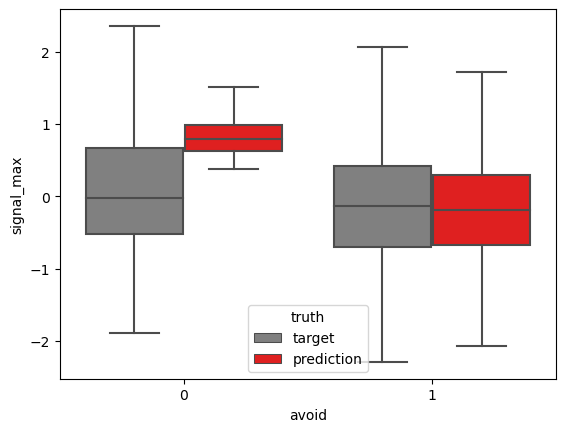

In [65]:
sns.boxplot(data=fp_only_df.query("sensor_DA == 1"),x = 'avoid', y = 'signal_max', hue = 'truth', palette = ['grey','red'], showfliers = False)

<Axes: xlabel='avoid', ylabel='signal_range'>

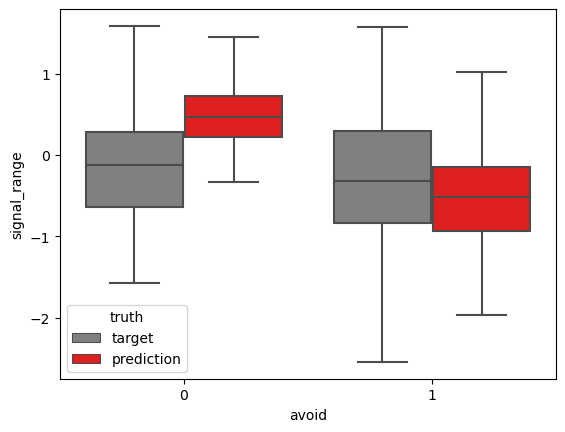

In [67]:
sns.boxplot(data=fp_only_df.query("sensor_D1 == 1"),x = 'avoid', y = 'signal_range', hue = 'truth', palette = ['grey','red'], showfliers = False)

<Axes: xlabel='avoid', ylabel='signal_max'>

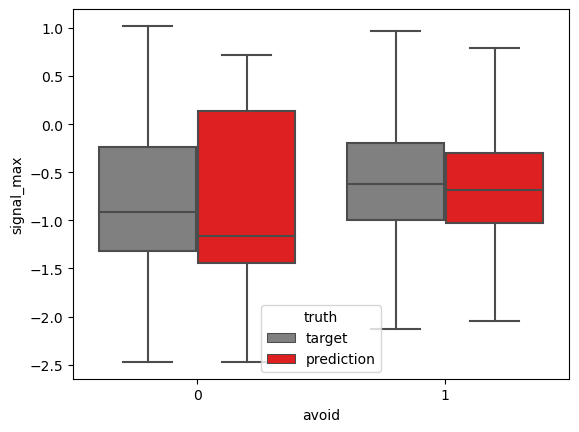

In [68]:
sns.boxplot(data=fp_only_df.query("sensor_D2 == 1"),x = 'avoid', y = 'signal_max', hue = 'truth', palette = ['grey','red'], showfliers = False)